# Binary Classification Deep Learning Model for [PROJECT NAME] Using Keras Version 4
### David Lowe
### December 16, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset contains various measurements of breast tissue samples for cancer diagnosis. It contains measurements such as the thickness of the clump, the uniformity of cell size and shape, the marginal adhesion, and so on. Dr. William H. Wolberg of the University of Wisconsin Hospitals in Madison is the original provider of this dataset.]

ANALYSIS: [Sample Paragraph - The baseline performance of the model achieved an average accuracy score of 96.95%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 96.94%. Furthermore, the final model processed the test dataset with an accuracy of 95.99%, which can indicate potentially a high-variance, over-fitting issue. We might need to acquire more data and/or apply regularization techniques during training before deploying the model for production use.]

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29]

One potential source of performance benchmarks: [https://www.kaggle.com/uciml/breast-cancer-wisconsin-data]

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_optimizer = K.optimizers.Adam(learning_rate=0.001)
default_epochs = 50
default_batches = 32

Num GPUs Available:  0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
# dest_file = os.path.basename(dataset_path)
# if (os.path.isfile(dest_file) == False) :
#     print('Downloading ' + dataset_path + ' as ' + dest_file)
#     with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
#         shutil.copyfileobj(in_resp, out_file)
#     print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

# inputFile = dest_file
attrNames = ['attr' + str(i).zfill(2) for i in range(1,10)]
colNames = ['id'] + attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, na_values=['?'])

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,target
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4
6,1018099,1,1,1,1,2,10.0,3,1,1,2
7,1018561,2,1,2,1,2,1.0,3,1,1,2
8,1033078,2,1,1,1,2,1.0,1,1,5,2
9,1033078,4,2,1,1,2,1.0,2,1,1,2


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id        699 non-null int64
attr01    699 non-null int64
attr02    699 non-null int64
attr03    699 non-null int64
attr04    699 non-null int64
attr05    699 non-null int64
attr06    683 non-null float64
attr07    699 non-null int64
attr08    699 non-null int64
attr09    699 non-null int64
target    699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


In [10]:
Xy_original.describe()

,id,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,target
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id         0
attr01     0
attr02     0
attr03     0
attr04     0
attr05     0
attr06    16
attr07     0
attr08     0
attr09     0
target     0
dtype: int64
Total number of NaN in the dataframe:  16


## 1.b) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['id'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
Xy_original['attr06'].fillna(value=Xy_original['attr06'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with R/M levels into categorical feature of 0/1
def reClassSomecol(target):
    if (target == 4): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,targetVar
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0
5,8,10,10,8,7,10.0,9,7,1,1
6,1,1,1,1,2,10.0,3,1,1,0
7,2,1,2,1,2,1.0,3,1,1,0
8,2,1,1,1,2,1.0,1,1,5,0
9,4,2,1,1,2,1.0,2,1,1,0


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
attr01       699 non-null int64
attr02       699 non-null int64
attr03       699 non-null int64
attr04       699 non-null int64
attr05       699 non-null int64
attr06       699 non-null float64
attr07       699 non-null int64
attr08       699 non-null int64
attr09       699 non-null int64
targetVar    699 non-null int64
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [14]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,targetVar
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

attr01       0
attr02       0
attr03       0
attr04       0
attr05       0
attr06       0
attr07       0
attr08       0
attr09       0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (699, 10) X_original.shape: (699, 9) y_original.shape: (699,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

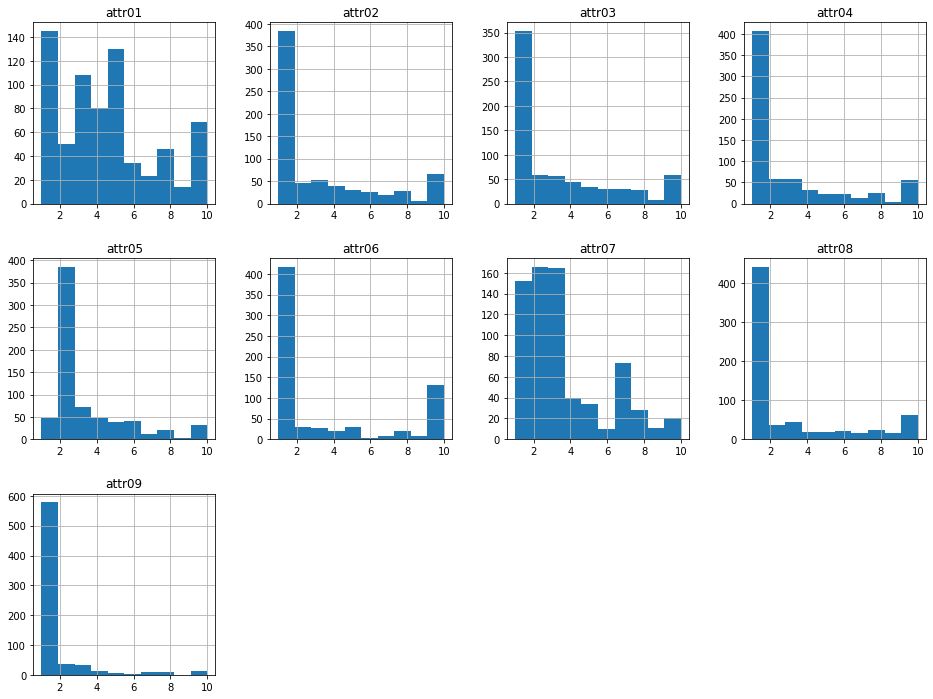

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['attr01', 'attr02', 'attr03', 'attr04', 'attr05', 'attr06', 'attr07', 'attr08', 'attr09']


In [21]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09
0,0.206936,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
1,0.206936,0.283845,0.266875,0.768621,1.710106,1.799664,-0.179662,-0.284112,-0.343912
2,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.410685,-0.179662,-0.611825,-0.343912
3,0.562336,1.595632,1.613773,-0.633247,-0.097628,0.141902,-0.179662,1.354454,-0.343912
4,-0.148465,-0.699995,-0.743299,0.067687,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
...,...,...,...,...,...,...,...,...,...
684,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
685,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
686,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
687,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.590067,0.043601,-0.343912


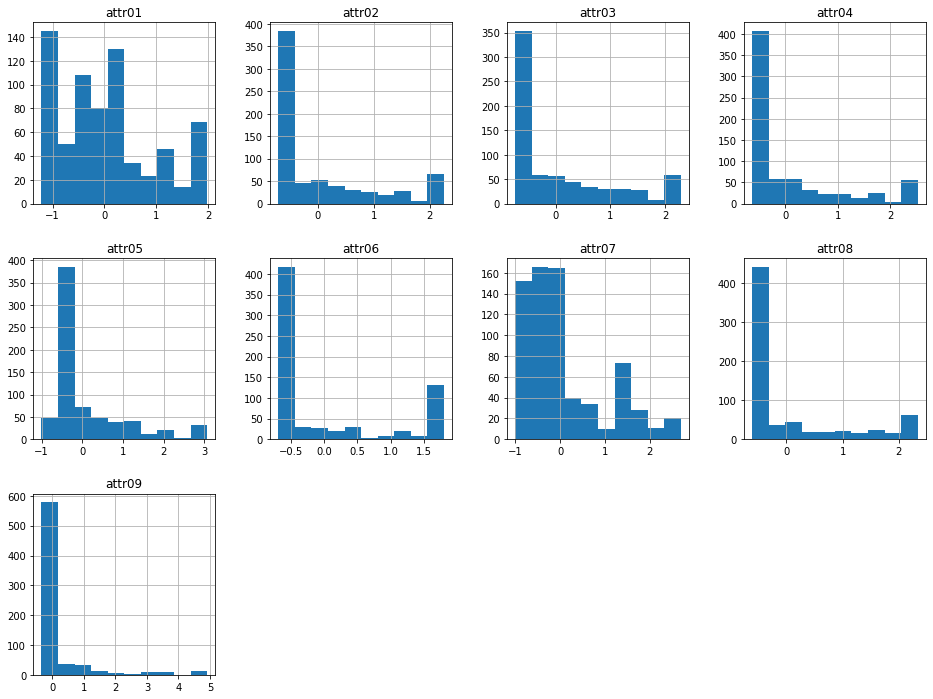

In [22]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [23]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

## 1.d) Splitting Data into Training and Test Sets

In [24]:
# Encode class values as integers and perform one-hot-encoding
# y_encoded = y_original.to_numpy()
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_encoded = encoder.transform(y_original)
print(y_encoded)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1
 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 1 1 1 0 1 0 

In [25]:
# Split the data further into training and test datasets
X_encoded = X_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (524, 9) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (524,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (175, 9) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (175,) y_test.type: <class 'numpy.ndarray'>


In [26]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [27]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [28]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(15, input_shape=(9,), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [29]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [30]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [31]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [32]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using k-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_810 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_4467 in device /job:localhost/replica:0/task:0/device:CPU:0


In [33]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [34]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(15, input_shape=(9,), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [36]:
startTimeModule = datetime.now()

# Create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.0010)
optz_2 = K.optimizers.Adam(learning_rate=0.0005)
optz_3 = K.optimizers.Adam(learning_rate=0.0001)
optimizer_grid = [optz_1, optz_2, optz_3]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2]
epoch_grid = [50]
batch_grid = [16, 32, 64]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
# n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
# grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


Executing op __inference_keras_scratch_graph_23615 in device /job:localhost/replica:0/task:0/device:CPU:0
Best: 0.969466 using {'batch_size': 16, 'epochs': 50, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f5f640ab190>, 'optimizer': <keras.optimizers.Adam object at 0x7f5f28051990>}
0.967557 (0.009699) with: {'batch_size': 16, 'epochs': 50, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f5f640ab190>, 'optimizer': <keras.optimizers.Adam object at 0x7f5f28051cd0>}
0.969466 (0.009329) with: {'batch_size': 16, 'epochs': 50, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f5f640ab190>, 'optimizer': <keras.optimizers.Adam object at 0x7f5f28051990>}
0.965649 (0.012952) with: {'batch_size': 16, 'epochs': 50, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f5f640ab190>, 'optimizer': <keras.optimizers.Adam object at 0x7f5f640ab510>}
0.969466 (0.012639) with: {'batch_size': 16, 'epochs': 50, 'kernel_init': <keras.initializers.Orthogonal object

In [37]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [38]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [39]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
model_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=0)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f5f28051990>, kernel=<keras.initializers.RandomNormal object at 0x7f5f640ab190>, epochs=50, batch_size=16
Executing op __inference_keras_scratch_graph_32735 in device /job:localhost/replica:0/task:0/device:CPU:0


In [41]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 15)                150       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 16        
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_13', 'trainable': True, 'batch_input_shape': (None, 9), 'dtype': 'float32', 'units': 15, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [43]:
# List all data points in model training history
print(model_hist.history.keys())

dict_keys(['loss', 'accuracy'])


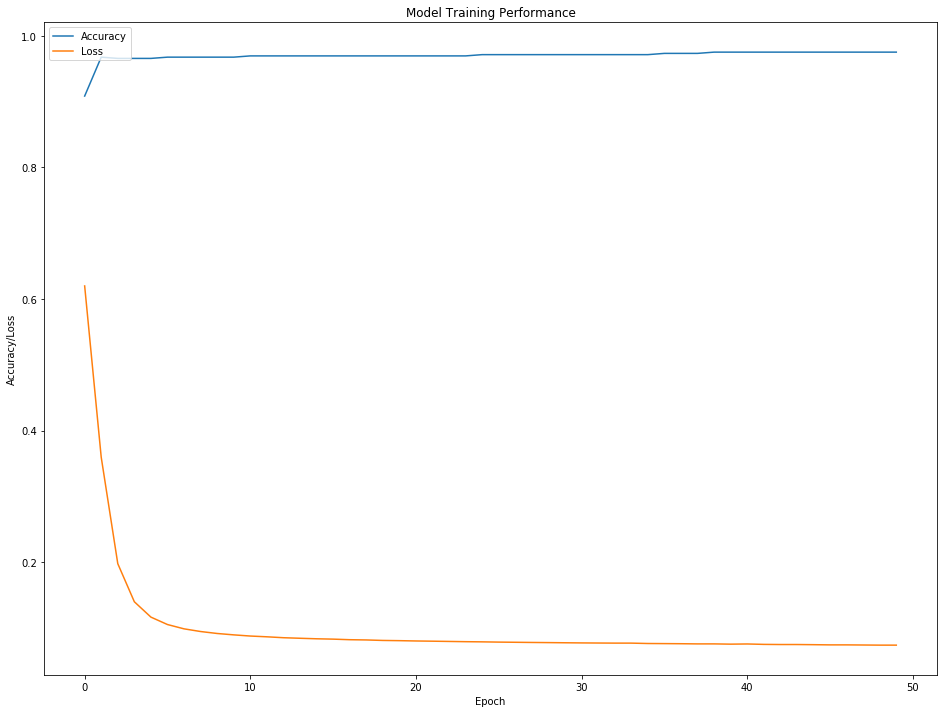

In [44]:
# Summarize model training hisotry for accuracy and loss
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['loss'])
plt.title('Model Training Performance')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [45]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %f" % (final_model.metrics_names[0], scores[0]))

Executing op __inference_keras_scratch_graph_41142 in device /job:localhost/replica:0/task:0/device:CPU:0
175/175 [==============================] - 0s 405us/step

accuracy: 95.999998%

loss: 0.074210


In [46]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %d (expected %d)' % (i, predictions[i], y_test[i]))

Executing op __inference_keras_scratch_graph_41192 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be 1 (expected 1)
Data item #1 predicted to be 1 (expected 1)
Data item #2 predicted to be 1 (expected 1)
Data item #3 predicted to be 0 (expected 0)
Data item #4 predicted to be 0 (expected 0)
Data item #5 predicted to be 1 (expected 1)
Data item #6 predicted to be 0 (expected 0)
Data item #7 predicted to be 1 (expected 1)
Data item #8 predicted to be 0 (expected 0)
Data item #9 predicted to be 1 (expected 1)
Data item #10 predicted to be 0 (expected 0)
Data item #11 predicted to be 1 (expected 1)
Data item #12 predicted to be 0 (expected 0)
Data item #13 predicted to be 0 (expected 0)
Data item #14 predicted to be 0 (expected 0)
Data item #15 predicted to be 0 (expected 0)
Data item #16 predicted to be 0 (expected 0)
Data item #17 predicted to be 0 (expected 0)
Data item #18 predicted to be 0 (expected 0)
Data item #19 predicted to be 0 (expected 0)


In [47]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:40.156550
